In [2]:
!pip install pyarrow

In [3]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import xgboost as xgb
import mlflow

/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/codespace/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
pd.__version__

'2.3.2'

In [21]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1758910416409, experiment_id='1', last_update_time=1758910416409, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [ ]:
######## dev stuff

2025/09/26 22:23:47 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/26 22:23:47 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1758910416409, experiment_id='1', last_update_time=1758910416409, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [21]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [23]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [24]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")

In [25]:
df[
    df.trip_type == 2
].count()

VendorID                 1238
lpep_pickup_datetime     1238
lpep_dropoff_datetime    1238
store_and_fwd_flag       1238
RatecodeID               1238
PULocationID             1238
DOLocationID             1238
passenger_count          1238
trip_distance            1238
fare_amount              1238
extra                    1238
mta_tax                  1238
tip_amount               1238
tolls_amount             1238
ehail_fee                   0
improvement_surcharge    1238
total_amount             1238
payment_type             1238
trip_type                1238
congestion_surcharge     1238
dtype: int64

In [26]:
df.lpep_dropoff_datetime.describe()

count                         76518
mean     2021-01-16 16:12:17.846781
min             2009-01-01 00:12:25
25%             2021-01-08 23:42:32
50%      2021-01-16 10:30:42.500000
75%             2021-01-24 09:55:45
max             2021-02-01 16:56:37
Name: lpep_dropoff_datetime, dtype: object

In [27]:
# df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
# df.lpep_pickup_datetime  = pd.to_datetime(df.lpep_pickup_datetime)

In [28]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [29]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [30]:
td = df.duration.iloc[0]

In [31]:
td.total_seconds() / 60

AttributeError: 'numpy.float64' object has no attribute 'total_seconds'

In [ ]:
sns.displot(df.duration)

In [ ]:
df.duration.describe()

In [ ]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

In [ ]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [32]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [33]:
df[categorical] = df[categorical].astype(str)

In [34]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [35]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [36]:
train_dicts

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '225', 'trip_distance': 0.0},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48},
 {'PU

In [37]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [38]:
X_train

<76518x508 sparse matrix of type '<class 'numpy.float64'>'
	with 229554 stored elements in Compressed Sparse Row format>

In [39]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [40]:
target = 'duration'
y_train = df[target].values

In [41]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

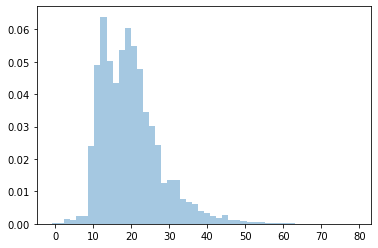

In [44]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [ ]:
mean_squared_error(y_train, y_pred, squared=False) # error about 9.7 munites, our baseline

In [ ]:
# here is start

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
path_to_file_jan = "data/green_tripdata_2021-01.parquet"
path_to_file_feb = "data/green_tripdata_2021-02.parquet"

df_train = read_dataframe(path_to_file_jan)
df_val = read_dataframe(path_to_file_feb)

In [8]:
len(df_train), len (df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479569957943581

In [26]:
# import os
# os.mkdir("results")
with mlflow.start_run():    
    mlflow.set_tag("musician", "roman")
    
    mlflow.log_param("train-data-path", path_to_file_jan)
    mlflow.log_param("valid-data-path", path_to_file_jan)
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/", artifact_path="models_pickle")
    

In [ ]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

In [17]:
# os.mkdir('models', exist_ok=True)
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
%%sh
ls

data
duration-prediction.ipynb
mlflow.db
mlruns
models
requirements.txt


In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [14]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [18]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

{'learning_rate': 0.24468699444477965,
 'max_depth': 41,
 'min_child_weight': 1.3245783379974427,
 'objective': 'reg:linear',
 'reg_alpha': 0.0837390361271741,
 'reg_lambda': 0.3387869476031274,
 'seed': 42}

In [37]:
params = {
    'learning_rate': 0.24468699444477965,
    'max_depth': 41,
    'min_child_weight': 1.3245783379974427,
    'objective': 'reg:linear',
    'reg_alpha': 0.0837390361271741,
    'reg_lambda': 0.3387869476031274,
    'seed': 42
}

def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']    
    df[categorical] = df[categorical].astype(str)
    
    return df

path_to_file_jan = "data/green_tripdata_2021-01.parquet"
path_to_file_feb = "data/green_tripdata_2021-02.parquet"

df_train = read_dataframe(path_to_file_jan)
df_val = read_dataframe(path_to_file_feb)

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

################################################

# mlflow.xgboost.autolog()

# booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=100,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=50
#         )
    

In [1]:
# 5 min

In [41]:
with mlflow.start_run():  
    
    best_params = {
        'learning_rate': 0.24468699444477965,
        'max_depth': 41,
        'min_child_weight': 1.3245783379974427,
        'objective': 'reg:linear',
        'reg_alpha': 0.0837390361271741,
        'reg_lambda': 0.3387869476031274,
        'seed': 42
    }
    mlflow.log_params(best_params)
    
    booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:04:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.29039
[1]	validation-rmse:8.98106
[2]	validation-rmse:8.11573
[3]	validation-rmse:7.55808
[4]	validation-rmse:7.20001
[5]	validation-rmse:6.97102
[6]	validation-rmse:6.81888
[7]	validation-rmse:6.71929
[8]	validation-rmse:6.65330
[9]	validation-rmse:6.60644
[10]	validation-rmse:6.57168
[11]	validation-rmse:6.54577
[12]	validation-rmse:6.52894
[13]	validation-rmse:6.51595
[14]	validation-rmse:6.50138
[15]	validation-rmse:6.49389
[16]	validation-rmse:6.48838
[17]	validation-rmse:6.48350
[18]	validation-rmse:6.48009
[19]	validation-rmse:6.47781
[20]	validation-rmse:6.47608
[21]	validation-rmse:6.47360
[22]	validation-rmse:6.47034
[23]	validation-rmse:6.46815
[24]	validation-rmse:6.46561
[25]	validation-rmse:6.46354
[26]	validation-rmse:6.46217
[27]	validation-rmse:6.45934
[28]	validation-rmse:6.45659
[29]	validation-rmse:6.45463
[30]	validation-rmse:6.45247
[31]	validation-rmse:6.45109
[32]	validation-rmse:6.44955
[33]	validation-rmse:6.44862
[34]	validation-rmse:6.

2025/09/27 00:04:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:04:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/09/27 00:04:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjtzjb0iv/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/09/27 00:04:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [40]:
mlflow.end_run()

MlflowException: The run 52a7037938c346eb83213f49e0ee7e26 must be in the 'active' state. Current state is deleted.

'/workspaces/mlops-zoomcamp/02-experiment-tracking/models/preprocess.b'

In [ ]:
import mlflow
          
mlflow.set_active_model(model_id="m-3028a75ebfe14eb3a37bbdafe34a506c")